In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier

In [177]:
import distribution_modules as dm
import density_estimation_modules as dem
import classification_modules as cm
import importlib

importlib.reload(dm)
importlib.reload(dem)
importlib.reload(cm)

<module 'classification_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\classification_modules.py'>

In [134]:
bounded_dists = dm.get_bounded_distribution()
bounded_dists

{'arcsine': <scipy.stats._distn_infrastructure.rv_frozen at 0x2287cb425e0>,
 'beta_1_2': <scipy.stats._distn_infrastructure.rv_frozen at 0x2287c95dfd0>,
 'powerlaw_0.3': <scipy.stats._distn_infrastructure.rv_frozen at 0x2287ccbc7c0>,
 'trapezoid_0.3_0.8': <scipy.stats._distn_infrastructure.rv_frozen at 0x2287cea28b0>,
 'traing_0.3': <scipy.stats._distn_infrastructure.rv_frozen at 0x2287cea2880>,
 'uniform': <scipy.stats._distn_infrastructure.rv_frozen at 0x2287cea22b0>}

In [135]:
# set configurations
sample_size = 500
nr_sample = 20
x = np.linspace(0,1,20)

In [136]:
kde_df = dem.get_kde(bounded_dists, nr_sample, sample_size, x)
kde_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,dist
0,0.916544,1.060729,1.058190,0.962609,0.844312,0.742177,0.669137,0.630961,0.629785,0.659038,...,0.733225,0.743839,0.745255,0.770946,0.849431,0.967903,1.057507,1.030103,0.851083,arcsine
1,0.931997,1.105952,1.140556,1.068421,0.950785,0.831977,0.730415,0.650014,0.589555,0.547742,...,0.533922,0.573477,0.645942,0.747319,0.869601,0.992540,1.071790,1.047250,0.886817,arcsine
2,0.856801,1.047807,1.104010,1.041399,0.920151,0.799312,0.711065,0.658818,0.628809,0.607331,...,0.600299,0.632051,0.684538,0.754190,0.849219,0.971010,1.077994,1.086474,0.937792,arcsine
3,0.919727,1.072235,1.069766,0.955113,0.807254,0.684745,0.609584,0.579278,0.581012,0.600334,...,0.654682,0.687110,0.730532,0.796272,0.894375,1.014292,1.105135,1.090478,0.927540,arcsine
4,0.992079,1.171835,1.189523,1.085548,0.935151,0.797944,0.703836,0.657853,0.648653,0.659577,...,0.694923,0.709758,0.727892,0.761416,0.817729,0.885198,0.925642,0.886062,0.737331,arcsine


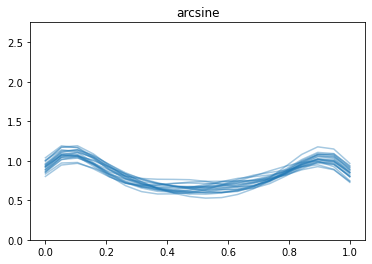

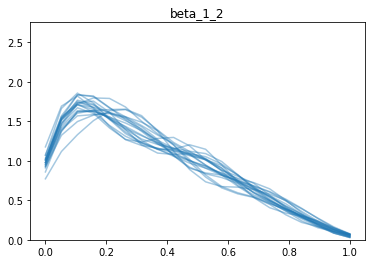

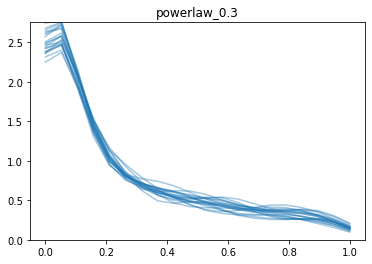

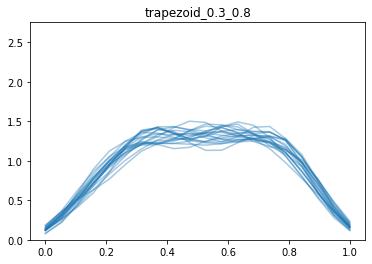

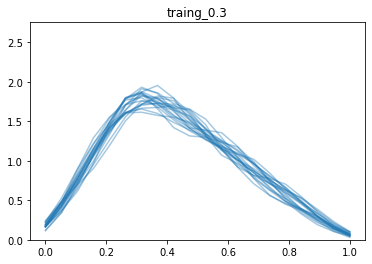

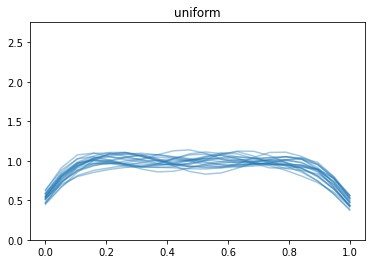

In [139]:
dem.get_kde_plot(bounded_dists, kde_df, nr_sample, sample_size, x)

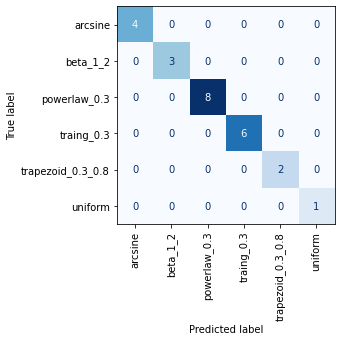

array([1., 1., 1., 1., 1.])

In [11]:
test_size = 0.2
cv = 5
cm.svm_model(kde_df, test_size, cv, plot=1)

In [12]:
# testing number of intervals vs accuracy
acc_mean = []
acc_std = []
intervals = list(range(10,200,5))

for i in intervals:
    x = np.linspace(0,1,i)
    kde_df = dem.get_kde(bounded_dists, nr_sample, sample_size, x)
    score = cm.svm_model(kde_df, test_size, cv)
    acc_mean.append(score.mean())
    acc_std.append(score.std())

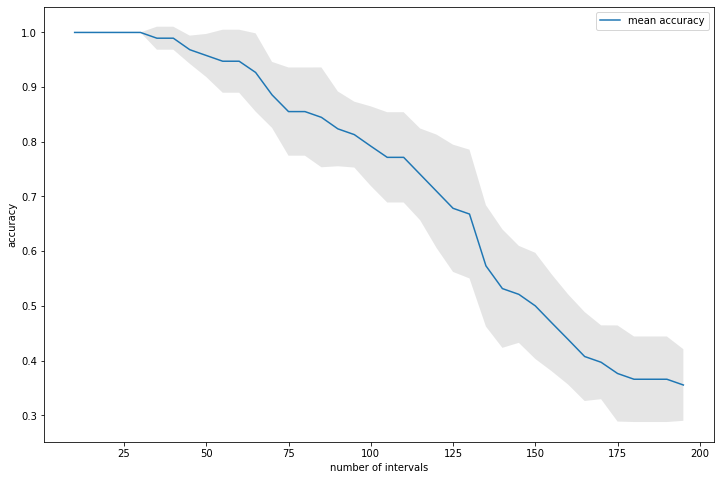

In [13]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
plt.plot(intervals,acc_mean, label='mean accuracy')

plt.gca().fill_between(intervals,
                       [i-j for i,j in zip(acc_mean, acc_std)], 
                       [i+j for i,j in zip(acc_mean, acc_std)],
                       facecolor='gray', 
                       alpha=0.2)

plt.xlabel('number of intervals')
plt.ylabel('accuracy')
plt.legend();

### long tail distributions

In [178]:
longtail_dists = dm.get_longtail_distribution()
longtail_dists

{'cauchy': <scipy.stats._distn_infrastructure.rv_frozen at 0x2287c838310>,
 'lognorm_1.5': <scipy.stats._distn_infrastructure.rv_frozen at 0x2287e6258b0>,
 'pareto_1.5': <scipy.stats._distn_infrastructure.rv_frozen at 0x2287d244220>,
 'weibull_min_0.4': <scipy.stats._distn_infrastructure.rv_frozen at 0x2287e416400>}

In [182]:
x = np.linspace(0,20,40)
bandwidth = 0.00001
kde_df_l = dem.get_kde_l(longtail_dists, nr_sample, sample_size, x, bandwidth)
kde_df_l.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,dist
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,3.555073e-248,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cauchy
1,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cauchy
2,0.0,4.985104e-266,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cauchy
3,0.0,0.000000e+00,1.009830e-136,4.269425e-13,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cauchy
4,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,7.575058e-19,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cauchy


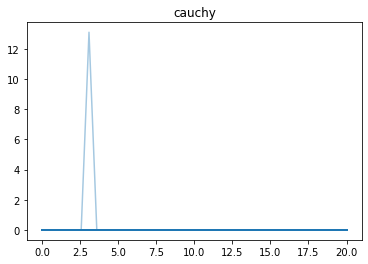

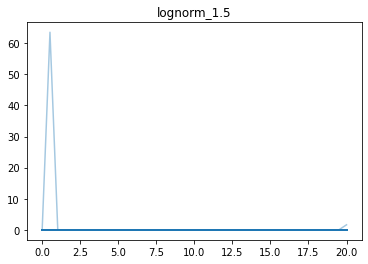

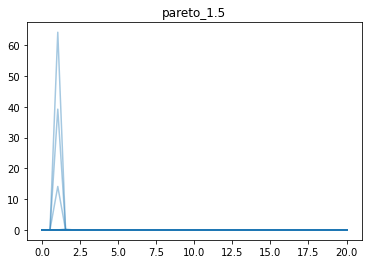

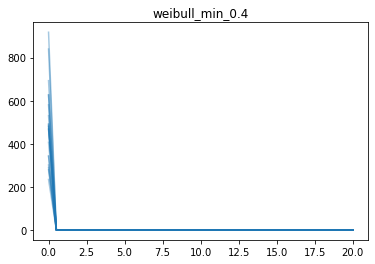

In [183]:
dem.get_kde_plot(longtail_dists, kde_df_l, nr_sample, sample_size, x)

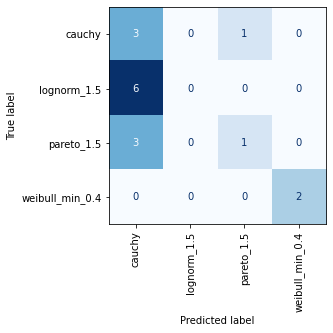

array([0.46153846, 0.38461538, 0.53846154, 0.61538462, 0.75      ])

In [184]:
test_size = 0.2
cv = 5
cm.svm_model(kde_df_l, test_size, cv, plot=1)

In [141]:
# testing number of intervals vs accuracy
acc_mean = []
acc_std = []
intervals = list(range(40,200,5))

for i in intervals:
    x = np.linspace(0,20,i)
    kde_df = dem.get_kde_l(longtail_dists, nr_sample, sample_size, x, 0.05)
    score = cm.svm_model(kde_df, test_size, cv)
    acc_mean.append(score.mean())
    acc_std.append(score.std())

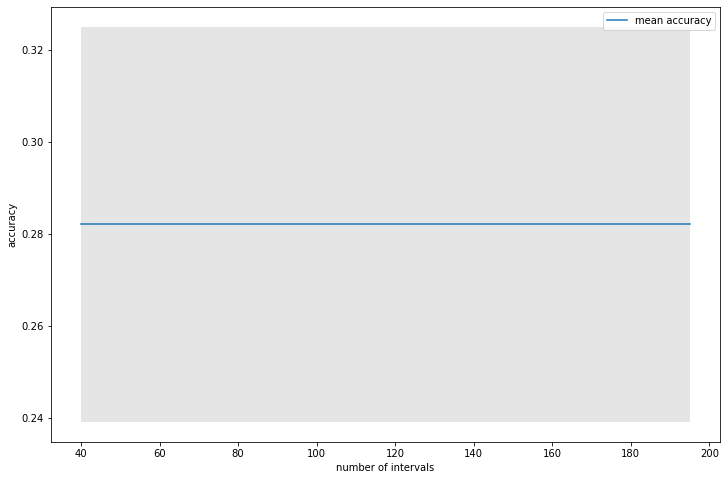

In [142]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
plt.plot(intervals,acc_mean, label='mean accuracy')

plt.gca().fill_between(intervals,
                       [i-j for i,j in zip(acc_mean, acc_std)], 
                       [i+j for i,j in zip(acc_mean, acc_std)],
                       facecolor='gray', 
                       alpha=0.2)

plt.xlabel('number of intervals')
plt.ylabel('accuracy')
plt.legend();

In [186]:
# testing bandwidth vs accuracy
acc_mean = []
acc_std = []
bandwidth = np.linspace(0.000001,0.005,20)
x = np.linspace(0,20,50)
for i in bandwidth:
    kde_df = dem.get_kde_l(longtail_dists, nr_sample, sample_size, x, i)
    score = cm.svm_model(kde_df, test_size, cv)
    acc_mean.append(score.mean())
    acc_std.append(score.std())

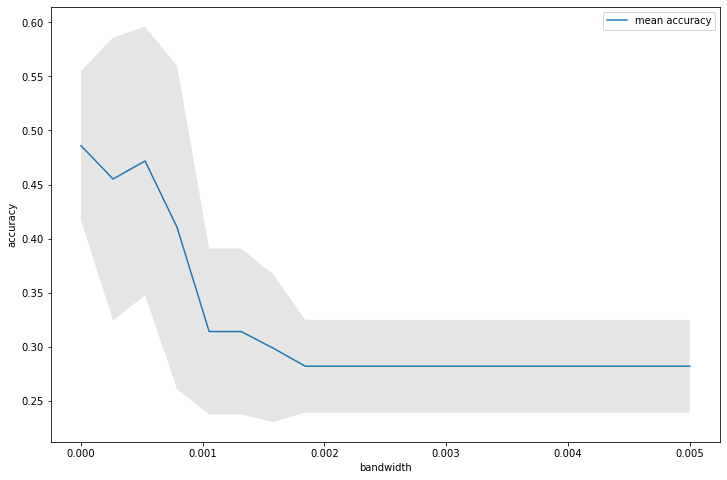

In [187]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
plt.plot(bandwidth,acc_mean, label='mean accuracy')

plt.gca().fill_between(bandwidth,
                       [i-j for i,j in zip(acc_mean, acc_std)], 
                       [i+j for i,j in zip(acc_mean, acc_std)],
                       facecolor='gray', 
                       alpha=0.2)

plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.legend();